In [ ]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
import pandas as pd
import numpy as np
import os
from psycopg2 import sql, connect

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
spark_version = 'spark-3.2.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-01-20 03:31:38--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  5.69MB/s    in 0.2s    

2022-01-20 03:31:38 (5.69 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [ ]:
# Store environmental variable
from getpass import getpass
password = getpass('Enter database password')

Enter database password··········


In [ ]:
try:
    # declare a new PostgreSQL connection object
    conn = connect(
        dbname = "data_final_project",
        user = "root",
        host = "finalproject.c0f9uvcdenwr.us-east-2.rds.amazonaws.com",
        port = "5433",
        password = password
    )

    # print the connection if successful
    print ("psycopg2 connection:", conn)

except Exception as err:
    print ("psycopg2 connect() ERROR:", err)
    conn = None


psycopg2 connection: <connection object at 0x7f3fce20a910; dsn: 'user=root password=xxx dbname=data_final_project host=finalproject.c0f9uvcdenwr.us-east-2.rds.amazonaws.com port=5433', closed: 0>


In [ ]:
cr = conn.cursor()
cr.execute('SELECT * FROM covid_surv;')
tmp = cr.fetchall()

In [ ]:
# Extract the column names
col_names = []
for elt in cr.description:
    col_names.append(elt[0])

# Create the dataframe from list of col_names
df = pd.DataFrame(tmp, columns=col_names)
df= df.rename(columns=str.lower)
df.head()

,month,state,county,age_range,sex,race,ethnicity,current_status,hospitalized,died
0,2021-08,CA,SANTA CLARA,50 to 64 years,Male,Multiple/Other,Non-Hispanic/Latino,Laboratory-confirmed case,No,Unknown
1,2021-08,PA,PHILADELPHIA,65+ years,Male,Unknown,Hispanic/Latino,Laboratory-confirmed case,Yes,Unknown
2,2021-08,IN,MARION,18 to 49 years,Male,Multiple/Other,NA,Laboratory-confirmed case,No,No
3,2021-08,WA,PIERCE,18 to 49 years,Male,White,Non-Hispanic/Latino,Probable Case,Yes,Unknown
4,2021-08,CA,SAN BERNARDINO,0 - 17 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,No,Unknown


In [ ]:
#yes and no to 1/0
df = df.replace({'Yes': 1, 'No':0})

In [ ]:
#standardize missing
df = df.replace(['Unknown', 'Missing', 'NA'], 'NA')

In [ ]:
#drop unused columns
df.drop(['county', 'current_status', 'month', 'hospitalized'], axis=1, inplace=True)

In [ ]:
#remove all missing values
df = df[df['state'] != "NA"]
df = df[df['age_range'] != "NA"]
df = df[df['sex'] != "NA"]
df = df[df['race'] != "NA"]
df = df[df['ethnicity'] != "NA"]
#df = df[df['hospitalized'] != "NA"]
df = df[df['died'] != "NA"]

In [ ]:
#convert columns
#df['hospitalized'] = df['hospitalized'].astype(float, errors = 'raise')
df['died'] = df['died'].astype(float, errors = 'raise')

In [ ]:
df = df.sort_values('state')
df.state.unique()

array(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'KS', 'MA', 'MD', 'MI', 'MN', 'NC', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'PA', 'RI', 'SC', 'TN', 'UT', 'VA', 'VT', 'WA', 'WI'],
      dtype=object)

In [ ]:
df_copy = df.copy().drop(['died'], axis=1).reset_index(drop=True)
print(df_copy.head())

  state       age_range     sex   race            ethnicity
0    AL  18 to 49 years  Female  White  Non-Hispanic/Latino
1    AL       65+ years  Female  White  Non-Hispanic/Latino
2    AL       65+ years  Female  White  Non-Hispanic/Latino
3    AL  18 to 49 years  Female  Black  Non-Hispanic/Latino
4    AL       65+ years  Female  White  Non-Hispanic/Latino


In [ ]:
df_orig = df.copy()
print(df.head())
print(df_orig.head())

       state       age_range     sex   race            ethnicity  died
47957     AL  18 to 49 years  Female  White  Non-Hispanic/Latino   0.0
337584    AL       65+ years  Female  White  Non-Hispanic/Latino   0.0
337579    AL       65+ years  Female  White  Non-Hispanic/Latino   0.0
150124    AL  18 to 49 years  Female  Black  Non-Hispanic/Latino   0.0
337574    AL       65+ years  Female  White  Non-Hispanic/Latino   0.0
       state       age_range     sex   race            ethnicity  died
47957     AL  18 to 49 years  Female  White  Non-Hispanic/Latino   0.0
337584    AL       65+ years  Female  White  Non-Hispanic/Latino   0.0
337579    AL       65+ years  Female  White  Non-Hispanic/Latino   0.0
150124    AL  18 to 49 years  Female  Black  Non-Hispanic/Latino   0.0
337574    AL       65+ years  Female  White  Non-Hispanic/Latino   0.0


ML model preparation

In [ ]:
cat = ['state', 'age_range', 'sex', 'race', 'ethnicity']

In [ ]:
# Create a LabelEncoder instance
le_state = LabelEncoder()
le_age = LabelEncoder()
le_sex = LabelEncoder()
le_race = LabelEncoder()
le_ethnicity = LabelEncoder()

In [ ]:
# Fit and transform the LabelEncoder using the categorical variable list
df['state'] = le_state.fit_transform(df['state'])
df['age_range'] = le_age.fit_transform(df['age_range'])
df['sex'] = le_sex.fit_transform(df['sex'])
df['race'] = le_race.fit_transform(df['race'])
df['ethnicity'] = le_ethnicity.fit_transform(df['ethnicity'])

In [ ]:
df

,state,age_range,sex,race,ethnicity,died
175,17,2,0,2,1,0.0
179,17,2,0,2,1,0.0
183,17,2,0,2,1,0.0
187,17,2,0,2,1,0.0
192,17,2,0,2,1,0.0
...,...,...,...,...,...,...
567847,12,2,0,4,1,0.0
567861,12,2,0,4,1,0.0
567896,12,2,0,4,1,0.0
567915,12,2,0,4,1,0.0


In [ ]:
#Convert pandas DF to pyspark DF
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("convert").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()
    
#Create PySpark DataFrame from Pandas
clean_df=spark.createDataFrame(df) 
clean_df.printSchema()
clean_df.show()

root
 |-- state: long (nullable = true)
 |-- age_range: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- race: long (nullable = true)
 |-- ethnicity: long (nullable = true)
 |-- died: double (nullable = true)

+-----+---------+---+----+---------+----+
|state|age_range|sex|race|ethnicity|died|
+-----+---------+---+----+---------+----+
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0|   2|        1| 0.0|
|   17|        2|  0| 

In [ ]:
#download file to RDS
mode = "append"
jdbc_url="jdbc:postgresql://finalproject.c0f9uvcdenwr.us-east-2.rds.amazonaws.com:5433/data_final_project"
config = {"user":"root",
          "password": password,
          "driver":"org.postgresql.Driver"}

In [ ]:
# Write DataFrame to final_model table in RDS
clean_df.write.jdbc(url=jdbc_url, table='final_model', mode=mode, properties=config)

In [ ]:
# Split our preprocessed data into our features and target arrays
y = df["died"]
X = df.drop(["died"], axis =1)

In [ ]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Random Forest


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import confusion_matrix
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,29735,12
Actual 1,465,271


In [ ]:
accuracy_score(y_test, predictions)

0.984351933864777

In [ ]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      1.00      0.37      0.99      0.61      0.39     29747
        1.0       0.96      0.37      1.00      0.53      0.61      0.34       736

avg / total       0.98      0.98      0.38      0.98      0.61      0.39     30483



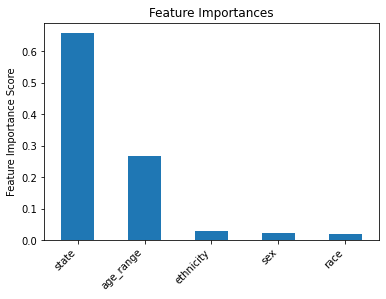

In [ ]:
import matplotlib.pylab as plt

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importances.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
rf_model.feature_importances_

array([0.65740415, 0.26822068, 0.02513371, 0.01893951, 0.03030195])

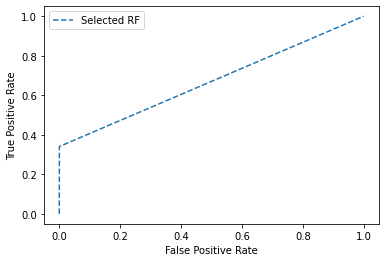

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='--', label='Selected RF')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

copy for predicting death

In [ ]:
#transform the LabelEncoder using the categorical variable list
df_copy['state'] = le_state.transform(df_copy['state'])
df_copy['age_range'] = le_age.transform(df_copy['age_range'])
df_copy['sex'] = le_sex.transform(df_copy['sex'])
df_copy['race'] = le_race.transform(df_copy['race'])
df_copy['ethnicity'] = le_ethnicity.transform(df_copy['ethnicity'])

In [ ]:
df_copy_scaled = X_scaler.transform(df_copy)

In [ ]:
patient_info = df_copy_scaled[len(df_copy_scaled)-1]
patient_info

array([ 2.16766503, -1.36856884, -0.93239233,  0.60890965,  0.38644148])

In [ ]:
#probability of death
patient_input = patient_info.reshape(1, -1)
prob_patient = rf_model.predict_proba(patient_input)
prob_patient_death = prob_patient[0][1]
print(f'proba patient: {prob_patient_death}')

proba patient: 0.0


In [ ]:
from sklearn.pipeline import make_pipeline
# Create pipeline Scaler + RF model
pipeline = make_pipeline(X_scaler, rf_model)

In [ ]:
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=128, random_state=78))])

saving files

In [ ]:
#joblib save rf model
from joblib import dump, load

dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

In [ ]:
dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [ ]:
# Save label encoders
dump(le_state, open('le_state.pkl', 'wb'))
dump(le_age, open('le_age.pkl', 'wb'))
dump(le_sex, open('le_sex.pkl', 'wb'))
dump(le_race, open('le_race.pkl', 'wb'))
dump(le_ethnicity, open('le_ethnicity.pkl', 'wb'))